# WeRateDogs Twitter Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gather Data</a></li>
<li><a href="#assess">Assess Data</a></li>
<li><a href="#clean">Clean Data</a></li>
<li><a href="#analyze">Analyze Data</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The dataset that I will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog.

1. Gather data from 3 difference sources.
	- Twitter data in cvs file provided by Udacity
	- Image prediction data from Udacity servers
	- Additional twitter data via http request’s get method
2. Assess visually and programmatically for data quality and tidiness issues.
3. Clean and fix data.
4. Analyze data.
    - How good the image prediction algorithm was to predict dog images?
    - Are top breeds of dogs associated with rating?
    - Which variables are associated with retweets and favorite counts?

In [1]:
import numpy as np
import pandas as pd
import requests
import os
import tweepy
import json
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sms;
%matplotlib inline

C:\Users\ayumi\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a id='gather'></a>
## Gather Data

Load The WeRateDogs Twitter archive

In [2]:
# Load The WeRateDogs Twitter archive
twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

Get tweet image predictions from Udacity Servers and save to 'image_predictions.tsv' file

In [4]:
# Get tweet image predictions from Udacity Servers and save to 'image_predictions.tsv' file
image_predictions_url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(image_predictions_url)
with open('image_predictions.tsv', mode='wb') as file:
    file.write(response.content)

Load tweet image predictions

In [5]:
# Load tweet image predictions
image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')

In [6]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Get additional data using Tweepy API and save to 'tweet_json.txt' file

In [7]:
# Tweepy OAuthentication 

# Setting up consumer/access token and secret
consumer_key = "<consumer key>"
consumer_secret = "<consumer secret>"
access_token = "<application key>"
access_secret = "<application secret>"

# Create an OAuthHandler instance
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
# Set access token
auth.set_access_token(access_token, access_secret)

# Create an API instance
api = tweepy.API(auth)

In [8]:
# Get additional data using Twitter API
tweet_ids = twitter_archive.tweet_id
batch_size = 100
count = 0

f = open('tweet_json.txt','w')

while batch_size*count < len(tweet_ids):
    
    # Calculate start and end index since we can only batch request 100 twitter ids at a time
    idx_start = batch_size*count
    idx_end = batch_size*(count+1) if batch_size*(count+1) < len(tweet_ids) else len(tweet_ids)
    
    # Get 100 tweet ids
    tweet_ids_request = tweet_ids[idx_start:idx_end]  
    
    # Batch requesting addtional information for 100 tweet ids
    # print('processing tweets %s - %s' % (idx_start+1, idx_end))
    tweets = api.statuses_lookup(id_=tweet_ids_request.tolist(), include_entities = False)

    # Save each tweet's additional data as json format in file 'tweet_json.txt'
    for tweet in tweets:
        json.dump(tweet._json, f)
        f.write("\n")
        
    count += 1

f.close()

Load additional twitter data, retreat_count and favorite_count.

In [9]:
# Load additional twitter data, retreat_count and favorite_count. 
cols = ['tweet_id', 'retweet_count', 'favorite_count']
tweets_list = []

with open('tweet_json.txt') as f:
    for line in f:
        # load each line of data as json format
        tweet = json.loads(line) 
        tweets_list.append([tweet['id'], tweet['retweet_count'], tweet['favorite_count']])
        
additional_data = pd.DataFrame(tweets_list, columns=cols)

In [10]:
additional_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id          2345 non-null int64
retweet_count     2345 non-null int64
favorite_count    2345 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


<a id='assess'></a>
## Assess Data

#### `twitter_archive` table

In [11]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


I've used Microsoft Excel to assess twitter_archive data visually.

Here are my assessments:
- Name column contains words like 'just', 'the', 'a'.
- Some tweets have more than 1 dog life stages.
- twitter id 786709082849828864 has wrong numerator and denominator. They should be 9.75/10 instead of 75/10.
- Extract numerator and denomintor from text columns and replace 'rating_numerator' and 'rating_denominator' with correct ones.
- Dog life stage variable is in 4 columns. ('doggo', 'floofer', 'pupper', and 'puppo')

Now I will assess twitter_archive data programmatically.

In [12]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

There are 2356 entries and 17 columns in twitter_archive.

These following columns have missing values: 
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls'
 
The data type of 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', and 'retweeted_status_user_id' columns are float.

The data type of the column 'timestamp' and 'retweeted_status_timestamp' are string(object).

Since we only want to use original tweets, I will remove 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' columns later.

In [13]:
twitter_archive['text'][0]

"This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU"

Text column contains text, numerator, denominator, and short-url.

In [14]:
twitter_archive['source'][0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [15]:
sum(twitter_archive['tweet_id'].duplicated())

0

There is no duplicated tweet_id.

In [16]:
twitter_archive['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [17]:
twitter_archive['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [18]:
twitter_archive['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [19]:
twitter_archive['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

The columns 'doggo', 'floofer', 'pupper', and 'puppo' only containts its own value and 'None'.

In [20]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

Checking tweets with numerator == 0.

In [21]:
# Set max_colwidth so that the context of 'text' column won't be truncated.
pd.set_option('max_colwidth',150)

In [22]:
twitter_archive[twitter_archive['rating_numerator'] == 0]['text']

315           When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag
1016    PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX
Name: text, dtype: object

0 seem to be a valid numerator.

Checking tweets with numerator which are greater than 100.

In [23]:
twitter_archive[twitter_archive['rating_numerator'] > 100]['text']

188                                                           @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research
189            @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10
290                                                                                                                               @markhoppus 182/10
313                                               @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
902                                                                   Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE
979                                                                   This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh
1120                       Say hello to this unbelievably well behaved squad of doggos. 204/170 would try 

These large numerators seem to be valid also.

In [24]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

There is 1 record contains denominator 0.

In [25]:
twitter_archive[twitter_archive['rating_denominator'] == 0]['text']

313    @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho
Name: text, dtype: object

twitter id 835246439529840640 has wrong numerator and denominator. They should be 13/10 instead of 960/0.

#### `image_predictions` table

In [26]:
image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


The format of predicted dog breeds in column p1, p2, and p3 are not consistent. 
Some are all lower cases, some use dash instead of underscore, etc.


'pg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', and 'p3_dog' should be part of the twitter_archive table.

In [27]:
image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


There are 2075 entries and 12 columns in image_prediction table. No data is missing.

In [28]:
sum(image_predictions['tweet_id'].duplicated())

0

There is no duplicated tweet_id.

In [29]:
sum(image_predictions['p1_conf'] > 1) + sum(image_predictions['p2_conf'] > 1) + sum(image_predictions['p3_conf'] > 1)

0

Confidence values do not exceed more than 1 for p1, p2, and p3.

#### `additional_data` table

In [30]:
additional_data.head()

,tweet_id,retweet_count,favorite_count
0,876484053909872640,2427,18769
1,886366144734445568,3214,21167
2,877611172832227328,81,0
3,888078434458587136,3515,21723
4,891689557279858688,8693,42139


'retweet_count' and 'favorite_count' should be part of the twitter_archive table

In [31]:
additional_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345 entries, 0 to 2344
Data columns (total 3 columns):
tweet_id          2345 non-null int64
retweet_count     2345 non-null int64
favorite_count    2345 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


There are 2175 entries and 3 columns in additional_data table.  No is data missing.

In [32]:
sum(additional_data['tweet_id'].duplicated())

0

There is no duplicated tweet_id.

In [33]:
sum(additional_data['retweet_count'] == 0)

1

In [34]:
sum(additional_data['favorite_count'] == 0)

170

There is 1 tweet which has retweet_count 0 and 170 tweets which have favorite_count 0.<br/>
They could be valid data as unpopular tweet could have 0 retweet and favorite vote, but further investigation is needed.

### Quality

##### `twitter_archive` table
- Dataset contains retweets in addition to original tweets.
- 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' columns are not needed.
- Missing data : 'in_reply_to_status_id', 'in_reply_to_user_id', and 'expanded_urls'
- Source column contains unnecessary and extra information
- Name column contains words like 'just', 'the', 'a'.
- Some tweets have more than 1 dog life stages.
- Erroneous datatypes : 'in_reply_to_status_id' and 'in_reply_to_user_id' are float.
- Erroneous datatypes : 'timestamp' is string(object).
- Erroneous datatypes : 'doggo', 'floofer', 'pupper', and 'puppo' only containts its own value and 'None'.
- Extract numerator and denomintor from text columns and replace 'rating_numerator' and 'rating_denominator' with correct ones.
- Text column contains text, numerator, denominator, and short-url.
- twitter id 835246439529840640 has wrong numerator and denominator. They should be 13/10 instead of 960/0.
- twitter id 786709082849828864 has wrong numerator and denominator. They should be 10/10 instead of 75/10.

##### `image_predictions` table
- The format of predicted dog breeds in column p1, p2, and p3 are not consistent.  Some are all lower cases, some use dash instead of underscore, etc. 

##### `additional_data` table

- There is 1 tweet which has retweet_count 0 and 170 tweets which have favorite_count 0. They could be valid data.

### Tidiness

##### `twitter_archive` table
- Dog life stage variable is in 4 columns.

##### `image_predictions` table
- 'pg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', and 'p3_dog' should be part of the twitter_archive table.

##### `additional_data` table
- 'retweet_count' and 'favorite_count' should be part of the twitter_archive table

<a id='clean'></a>
## Clean Data

Prior to cleaning, copies of the original data are made.

In [35]:
# Copy original dataframes to clean versions
twitter_archive_clean = twitter_archive.copy()
image_predictions_clean = image_predictions.copy()
additional_data_clean = additional_data.copy()

### Quality

###### `twitter_archive` : Dataset contains retweets in addition to original tweets.

###### Define
Remove retweets since we only want original tweets. 

###### Code

In [36]:
sum(twitter_archive_clean['retweeted_status_id'].notnull())

181

There are 181 retweet entries.

In [37]:
# Excluding retweets since we only want original tweets. 
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean['retweeted_status_id'].isnull()]
# Reset index
twitter_archive_clean = twitter_archive_clean.reset_index(drop=True)

###### Test

In [38]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

Retweets are dropped. (2356 - 181 = 2175)

### Quality

###### `twitter_archive` : 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' columns are not needed.

###### Define
Delete 'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' columns

###### Code

In [39]:
twitter_archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

###### Test

In [40]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 14 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 238.0+ KB


'retweeted_status_id', 'retweeted_status_user_id', and 'retweeted_status_timestamp' are dropped.

### Missing Data

###### `twitter_archive` : Missing data in columns 'in_reply_to_status_id', 'in_reply_to_user_id', and 'expanded_urls' 

###### Define
Unless a tweet has reply, values for 'in_reply_to_status_id' and 'in_reply_to_user_id' columns will not be present. This issue will not be fixed.

'extended_url' is missing because it's missing a short-url in text column. There must be a way to get an extended_url from twetter_id.  However, I will not be using 'extended_url' for my analysis nor visualization, so I am going to delete it.

###### Code

In [41]:
twitter_archive_clean = twitter_archive_clean.drop('expanded_urls', axis=1)

###### Test

In [42]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 13 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
dtypes: float64(2), int64(3), object(8)
memory usage: 221.0+ KB


'extended_url' column is dropped.

### Tidiness

###### `twitter_archive` : Dog life stage variable is in 4 columns.

###### Define
Melt 'doggo', 'floofer', 'pupper', and 'puppo' columns to a 'life_stage' column. Drop the immediate 'life_stage_category' column.

###### Code

In [43]:
twitter_archive_clean = pd.melt(twitter_archive_clean, id_vars=[
    'tweet_id',
    'in_reply_to_status_id',
    'in_reply_to_user_id',
    'timestamp',
    'source',
    'text',
    'rating_numerator',
    'rating_denominator',
    'name'
    ],
    value_vars=['doggo', 'floofer', 'pupper', 'puppo'], var_name='life_stage_category', value_name='life_stage')

In [44]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,life_stage_category,life_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13,10,Phineas,doggo,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https:/...",13,10,Tilly,doggo,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12,10,Archie,doggo,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13,10,Darla,doggo,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https:/...",12,10,Franklin,doggo,None


In [45]:
# Drop 'life_stage_category column
twitter_archive_clean = twitter_archive_clean.drop('life_stage_category', axis=1)

In [46]:
# Drop duplicated rows
twitter_archive_clean = twitter_archive_clean.drop_duplicates()

In [47]:
# Subset all duplicated tweet_ids 
duplicated_tweets = twitter_archive_clean[twitter_archive_clean['tweet_id'].duplicated(keep=False)]

In [48]:
# Drop all rows which have 'None' as life_stage from duplicated_tweets
duplicated_tweets = duplicated_tweets[duplicated_tweets['life_stage'] != 'None']

duplicated_tweets contains tweets with at least 1 life_stages

In [49]:
# Remove all duplicated tweets
twitter_archive_clean = twitter_archive_clean[~twitter_archive_clean['tweet_id'].duplicated(keep=False)]

twitter_archive_clean now contains tweets without any life_stages.

In [50]:
# Exclude all duplicated tweets from duplicated_tweets as some tweets have more than 1 life_stage
one_life_stage_tweets = duplicated_tweets[~duplicated_tweets['tweet_id'].duplicated(keep=False)]

one_life_stage_tweets contains tweets with only 1 life_stage.

In [51]:
# Keep all duplicated tweets from duplicated_tweets
multiple_life_stages_tweets = duplicated_tweets[duplicated_tweets['tweet_id'].duplicated(keep=False)]

multiple_life_stages_tweets contains tweets with more than 1 life stages.

In [52]:
multiple_life_stages_tweets[multiple_life_stages_tweets['tweet_id'].duplicated()][['tweet_id', 'text']]

,tweet_id,text
2347,854010172552949760,"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https..."
4732,817777686764523521,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https..."
4792,808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho
4817,802265048156610565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze"
4824,801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj
4917,785639753186217984,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https...
4943,781308096455073793,"Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u"
5072,759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll"
5131,751583847268179968,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8
5235,741067306818797568,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC


Looking at these 12 tweets, there are multiple tweets talks about 2 dogs. <br/>
This is why these tweets have more then 1 life stages.  

I will assign 'multi' for these tweets.  Others, I will hand pick correct one by investigating text column.

In [53]:
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 854010172552949760, 'life_stage'] = 'floofer'
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 817777686764523521, 'life_stage'] = 'pupper'
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 808106460588765185, 'life_stage'] = 'multi'
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 802265048156610565, 'life_stage'] = 'multi'
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 801115127852503040, 'life_stage'] = 'pupper'
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 785639753186217984, 'life_stage'] = 'doggo'
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 781308096455073793, 'life_stage'] = 'multi'
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 759793422261743616, 'life_stage'] = 'multi'
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 751583847268179968, 'life_stage'] = 'None'
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 741067306818797568, 'life_stage'] = 'multi'
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 733109485275860992, 'life_stage'] = 'multi'
multiple_life_stages_tweets.loc[multiple_life_stages_tweets['tweet_id'] == 855851453814013952, 'life_stage'] = 'multi'

C:\Users\ayumi\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [54]:
# Remove duplidates
multiple_life_stages_tweets = multiple_life_stages_tweets[multiple_life_stages_tweets.duplicated()]

In [55]:
multiple_life_stages_tweets

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,life_stage
2347,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https...",11,10,None,floofer
4732,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https...",13,10,Dido,pupper
4792,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,12,10,None,multi
4817,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",11,10,None,multi
4824,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,12,10,Bones,pupper
4917,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https...,10,10,Pinot,doggo
4943,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",12,10,None,multi
5072,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",12,10,Maggie,multi
5131,751583847268179968,NaN,NaN,2016-07-09 01:08:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,5,10,None,None
5235,741067306818797568,NaN,NaN,2016-06-10 00:39:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,12,10,just,multi


Correct life stage is assigned for all rows in multiple_life_stages_tweets.

Now put everything back together.

twitter_archive_clean - tweets without any life stages<br/>
one_life_stage_tweets - tweets with 1 life stage<br/>
multiple_life_stages_tweets - tweets with more than 1 life stages<br/>

In [56]:
# Append all the data back to twitter_archive_clean
twitter_archive_clean = twitter_archive_clean.append(one_life_stage_tweets)
twitter_archive_clean = twitter_archive_clean.append(multiple_life_stages_tweets)

# Reset index
twitter_archive_clean = twitter_archive_clean.reset_index(drop=True)

###### Test

In [57]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 10 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
life_stage               2175 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 170.0+ KB


There are 2175 entries, and no data is missing from life_stage column.

### Quality

###### `twitter_archive` : Source column contains unnecessary and extra information.

###### Define
It needs to be cleaned up so that it only contains 'source' informaiton.

###### Code

In [58]:
twitter_archive_clean['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2042
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       31
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [59]:
# Extract hyperlink text
twitter_archive_clean['source'] = twitter_archive_clean['source'].str.extract('>(.*)<\/a>', expand=True)

###### Test

In [60]:
twitter_archive_clean['source'].value_counts()

Twitter for iPhone     2042
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

Source column now contains only 'source' information.

### Quality

###### `twitter_archive` : Name column contains words like 'just', 'the', 'a'.

###### Define
Extract name from text column.  If extracted word doesn't seem like a name, then they need to be changed to 'None'.

Here are patterns to find dog name in text column.
1. This is Zoey.
2. Meet Jax.
3. Here is George.
4. Say hello to Oakley.

###### Code

Extract name using 4 patterns identified above.

In [61]:
# Extract Name - This is Zoey pattern
extracted_this_is = twitter_archive_clean['text'].str.extract('This is (\w+)', expand=False)

In [62]:
# Extract Name - Meet Jax pattern
extracted_meet = twitter_archive_clean['text'].str.extract('Meet (\w+)', expand=False)

In [63]:
# Extract Name - Here is George pattern
extracted_here = twitter_archive_clean['text'].str.extract('Here is (\w+)', expand=False)

In [64]:
# Extract Name - Say hello to Oakley pattern
extracted_say = twitter_archive_clean['text'].str.extract('Say hello to (\w+)', expand=False)

In [65]:
# Create new dataframe
extracted_word = pd.DataFrame({"this_is": extracted_this_is, "meet": extracted_meet, "here": extracted_here, 'say': extracted_say})

In [66]:
extracted_word.head()

,here,meet,say,this_is
0,NaN,NaN,NaN,Phineas
1,NaN,NaN,NaN,Tilly
2,NaN,NaN,NaN,Archie
3,NaN,NaN,NaN,Darla
4,NaN,NaN,NaN,Franklin


In [67]:
# Replace Nan with None since name column is not numbers
extracted_word = extracted_word.where(extracted_word.notnull(), None)

Add count to each matched pattern and calculate how many names are found for each tweet.

In [68]:
# ########################################################################
# I was trying to use .apply() to get sum of count,
# but it throws an error, and I couldn't figure out how to fix it.
#
# I'm gonna do it very ugly way.
# Create count for each pattern, using 1 or 1 and just do simple addition
# to create name count,
# -------------------------------------------------------------------------
#def count_name(x):
#    return \
#        sum(x['this_is'].notnull()) + \
#        sum(x['meet'].notnull()) + \
#        sum(x['here'].notnull()) + \
#        sum(x['say'].notnull())
#        
#extracted_word['name_count'] = extracted_word.apply(count_name, axis=1)
#---------------------------------------------------------------------------
# AttributeError: ("'str' object has no attribute 'notnull'", 'occurred at index 0')
# ########################################################################

# Create count for each patter using 0 and 1
extracted_word['this_is_count'] = np.where(extracted_word['this_is'].notnull(), 1, 0)
extracted_word['meet_count'] = np.where(extracted_word['meet'].notnull(), 1, 0)
extracted_word['here_count'] = np.where(extracted_word['here'].notnull(), 1, 0)
extracted_word['say_count'] = np.where(extracted_word['say'].notnull(), 1, 0)

# Add them all to craete name_count
extracted_word['name_count'] = extracted_word['this_is_count'] + \
extracted_word['meet_count'] + extracted_word['here_count'] + extracted_word['say_count']

Find tweets which had more than 1 name found.

In [69]:
# Find tweets which had more than 1 name found.
extracted_word[extracted_word['name_count'] > 1]

,here,meet,say,this_is,this_is_count,meet_count,here_count,say_count,name_count
551,None,None,Carbon,his,1,0,0,1,2
1193,None,None,Lupe,how,1,0,0,1,2


Manually clean these 2 tweets. 

Since names found by 'Say hello to ...' pattern is actual name, they should be used as name for these 2 tweets.<br/>
Replacing name found by 'This is ...' pattern to 'None'.

In [70]:
# Replace 'his' and 'how' in 'this_is' column with None
extracted_word['this_is'] = np.where(extracted_word['this_is'] == 'his', None, extracted_word['this_is'])
extracted_word['this_is'] = np.where(extracted_word['this_is'] == 'how', None, extracted_word['this_is'])

In [71]:
extracted_word[extracted_word['name_count'] > 1]

,here,meet,say,this_is,this_is_count,meet_count,here_count,say_count,name_count
551,None,None,Carbon,None,1,0,0,1,2
1193,None,None,Lupe,None,1,0,0,1,2


In [72]:
# drop count columns
extracted_word = extracted_word.drop(['this_is_count', 'meet_count', 'here_count', 'say_count', 'name_count'], axis=1)

In [73]:
extracted_word.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 4 columns):
here       13 non-null object
meet       216 non-null object
say        95 non-null object
this_is    1170 non-null object
dtypes: object(4)
memory usage: 68.0+ KB


count columns are dropped.

Create 'name' column from name found by 4 patterns. 

In [74]:
# Find name either name extracted from 
# 'This is ..' pattern, 'Meet ..' pattern, 
# 'Here is ..' pattern, or 'Say hello to ..' pattern.
extracted_word['name'] = np.where(extracted_word['this_is'].notnull(), extracted_word['this_is'], extracted_word['meet'])
extracted_word['name'] = np.where(extracted_word['name'].notnull(), extracted_word['name'], extracted_word['here'])
extracted_word['name'] = np.where(extracted_word['name'].notnull(), extracted_word['name'], extracted_word['say'])

In [75]:
extracted_word.sample(10)

,here,meet,say,this_is,name
1145,None,None,None,Kramer,Kramer
40,None,None,None,Stanley,Stanley
477,None,None,None,Rusty,Rusty
764,None,None,None,Solomon,Solomon
534,None,Roosevelt,None,None,Roosevelt
791,None,None,None,Lola,Lola
1734,None,Olive,None,None,Olive
1335,None,Vinnie,None,None,Vinnie
212,None,None,None,Odie,Odie
463,None,None,None,Moose,Moose


Find name actually not a name (like 'just', 'the', 'a', etc)

In [76]:
# Find name like 'just', 'the', 'a', etc
extracted_word['cap_test'] = extracted_word['name'].str.match('^[A-Z]')

In [77]:
extracted_word[extracted_word['cap_test'] == False].sample(5)

,here,meet,say,this_is,name,cap_test
548,None,None,None,very,very,False
701,None,None,None,very,very,False
1748,None,None,None,a,a,False
1274,None,None,None,officially,officially,False
266,None,None,None,one,one,False


Replace words (like 'just', 'the', 'a', etc) with 'None'

In [78]:
# Replace words not names with None
extracted_word['name'] = np.where(extracted_word['cap_test'] == False, None, extracted_word['name'])

In [79]:
extracted_word[extracted_word['cap_test'] == False].sample(5)

,here,meet,say,this_is,name,cap_test
1681,None,None,None,an,None,False
1762,None,None,None,a,None,False
1786,None,None,None,a,None,False
1828,a,None,None,None,None,False
2172,None,None,None,just,None,False


In [80]:
# None doesn't get written to csv file. Manually assining word 'None'
extracted_word['name'] = np.where(extracted_word['name'].isnull(), 'None', extracted_word['name'])

Replace name column in twitter_archive_clean with extracted names.

In [81]:
# Replace name column in twitter_archive_clean with 'names in extracted_word
twitter_archive_clean['name'] = extracted_word['name']

###### Test

Make sure names like 'just' and 'the' are gone.

In [82]:
twitter_archive_clean[twitter_archive_clean[twitter_archive_clean.notnull()]['text'].str.match('This is just')].name

1496    None
2025    None
2172    None
Name: name, dtype: object

In [83]:
twitter_archive_clean[twitter_archive_clean[twitter_archive_clean.notnull()]['text'].str.match('This is the')].name

1331    None
1514    None
1820    None
2055    None
2095    None
Name: name, dtype: object

### Quality

###### `twitter_archive` : Some tweets have more than 1 dog life stages.

###### Define
This quality issue was addressed in tidiness issue "Dog life stage variable is in 4 columns" above. No further work needed.

###### Code
N/A

###### Test
N/A

### Quality

###### `twitter_archive` : Erroneous datatypes : 'in_reply_to_status_id' and 'in_reply_to_user_id' are float.

###### Define
Convert 'in_reply_to_status_id' and 'in_reply_to_user_id' to integer data type.

###### Code

In [84]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 10 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
life_stage               2175 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 170.0+ KB


Before I can convert data type to int, NaN needs to be replaced with 0 for these columns.

In [85]:
# Replace NaN with 0
twitter_archive_clean['in_reply_to_status_id'].fillna(value=0, inplace=True)
twitter_archive_clean['in_reply_to_user_id'].fillna(value=0, inplace=True)

In [86]:
# Check there is no NaN
sum(twitter_archive_clean['in_reply_to_status_id'].isnull()) + sum(twitter_archive_clean['in_reply_to_user_id'].isnull()) 

0

Convert 'in_reply_to_status_id' and 'in_reply_to_user_id' to integer data type.

In [87]:
# Convert to int data type
twitter_archive_clean['in_reply_to_status_id'] = twitter_archive_clean['in_reply_to_status_id'].astype(int)
twitter_archive_clean['in_reply_to_user_id'] = twitter_archive_clean['in_reply_to_user_id'].astype(int)

###### Test

In [88]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 10 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    2175 non-null int32
in_reply_to_user_id      2175 non-null int32
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
life_stage               2175 non-null object
dtypes: int32(2), int64(3), object(5)
memory usage: 153.0+ KB


Data type of 'in_reply_to_status_id' and 'in_reply_to_user_id' is changed to integer.

###### `twitter_archive` : Erroneous datatypes : 'timestamp' is string(object).

###### Define
Convert 'timestamp' to datetime data type. 

###### Code

In [89]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

###### Test

In [90]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 10 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    2175 non-null int32
in_reply_to_user_id      2175 non-null int32
timestamp                2175 non-null datetime64[ns]
source                   2175 non-null object
text                     2175 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
life_stage               2175 non-null object
dtypes: datetime64[ns](1), int32(2), int64(3), object(4)
memory usage: 153.0+ KB


Data type of 'timestamp' is changed to datetime.

### Quality

###### `twitter_archive` : Erroneous datatypes : 'doggo', 'floofer', 'pupper', and 'puppo' only containts its own value and 'None'.

###### Define
They could have been converted to boolean data types, but this quality issue was addressed in tidiness issue "Dog life stage variable is in 4 columns" above.  Instead of converting these 4 columns to boolean data type, new variable life_style was created. No further cleaning needed.

###### Code
N/A

###### Test
N/A

### Quality

###### `twitter_archive` : Extract numerator and denomintor from text columns and replace 'rating_numerator' and 'rating_denominator' with correct ones.

###### Define
According to Project Details, 'rating_numerator' and 'rating_denominator' columns might not contain correct values. I'm going to newly extract numerator and denominator from text columns and replace them in 'rating_numerator' and 'rating_denominator' columns.

###### Code

Extract numbers before '/' and after from text column. Some tweets contain more than 1 ratings.

In [91]:
# Extract numbers before '/' and after (\d+)\/(\d+) from text column
extracted = twitter_archive_clean['text'].str.extractall('(\d+)\/(\d+)').unstack()

In [92]:
extracted.head()

0               1            
match   0     1     2   0     1     2
0      13  None  None  10  None  None
1      13  None  None  10  None  None
2      12  None  None  10  None  None
3      13  None  None  10  None  None
4      12  None  None  10  None  None

In [93]:
# Replace 'None' with NaN since these are numbers
extracted.fillna(value=np.nan, inplace=True)
extracted.head()

0             1          
match   0    1    2   0    1    2
0      13  NaN  NaN  10  NaN  NaN
1      13  NaN  NaN  10  NaN  NaN
2      12  NaN  NaN  10  NaN  NaN
3      13  NaN  NaN  10  NaN  NaN
4      12  NaN  NaN  10  NaN  NaN

First, find any text which had 3 matched ratings.

In [94]:
extracted[extracted[0][2].notnull()].count()

   match
0  0        1
   1        1
   2        1
1  0        1
   1        1
   2        1
dtype: int64

It seems like there is only 1 tweet having 3 matched ratings.

In [95]:
twitter_archive_clean.iloc[extracted[extracted[0][2].notnull()].index[0]]['tweet_id'], \
twitter_archive_clean.iloc[extracted[extracted[0][2].notnull()].index[0]]['text']

(672248013293752320,
 '10/10 for dog. 7/10 for cat. 12/10 for human. Much skill. Would pet all https://t.co/uhx5gfpx5k')

By investigating the text column, the correct numerator and denominator for tweet_id 672248013293752320 is 10/10.

In [96]:
twitter_archive_clean.iloc[extracted[extracted[0][2].notnull()].index[0]]['rating_numerator'], \
twitter_archive_clean.iloc[extracted[extracted[0][2].notnull()].index[0]]['rating_denominator']

(10, 10)

Comfirmed that tweet_id 672248013293752320 has the correct numerator and denominator.

Now investigating any tweets which had 2 matched ratings.

In [97]:
extracted[extracted[0][1].notnull()].count()

   match
0  0        30
   1        30
   2         1
1  0        30
   1        30
   2         1
dtype: int64

There are 30 tweets with 2 matched ratings.

In [98]:
extracted.head()

0             1          
match   0    1    2   0    1    2
0      13  NaN  NaN  10  NaN  NaN
1      13  NaN  NaN  10  NaN  NaN
2      12  NaN  NaN  10  NaN  NaN
3      13  NaN  NaN  10  NaN  NaN
4      12  NaN  NaN  10  NaN  NaN

Create new dataframe with current numerator and denominator & 2 matched numerators and denominators for easy comparisons and evlauation.

In [99]:
# Subset tweet_id, text, numerator and denominator from twitter_archive_clean
# for all tweets which had 2 matched pattern.
two_pattern = pd.DataFrame(data = { \
    'tweet_id' : twitter_archive_clean[extracted[0][1].notnull()]['tweet_id'], \
    'text' : twitter_archive_clean[extracted[0][1].notnull()]['text'], \
    'tac_nume' : twitter_archive_clean[extracted[0][1].notnull()]['rating_numerator'], \
    'tac_deno' : twitter_archive_clean[extracted[0][1].notnull()]['rating_denominator']     
})

In [100]:
# Subset 1st and 2nd mattched numerator and denominator.
extracted_two_pattern = extracted[extracted[0][1].notnull()]

extracted_two_pattern_rating = pd.DataFrame(data = { \
    'nume1' : extracted_two_pattern[0][0], \
    'deno1' : extracted_two_pattern[1][0], \
    'nume2' : extracted_two_pattern[0][1], \
    'deno2' : extracted_two_pattern[1][1] \
}) 

In [101]:
# Join them together for new table
two_pattern = two_pattern.join(extracted_two_pattern_rating)

In [102]:
two_pattern.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 45 to 2126
Data columns (total 8 columns):
tac_deno    30 non-null int64
tac_nume    30 non-null int64
text        30 non-null object
tweet_id    30 non-null int64
deno1       30 non-null object
deno2       30 non-null object
nume1       30 non-null object
nume2       30 non-null object
dtypes: int64(3), object(5)
memory usage: 3.4+ KB


Change data type of deno1, deno2, nume1, nume2 to int

In [103]:
# Change data type to int
two_pattern['deno1'] = two_pattern['deno1'].astype(int)
two_pattern['deno2'] = two_pattern['deno2'].astype(int)
two_pattern['nume1'] = two_pattern['nume1'].astype(int)
two_pattern['nume2'] = two_pattern['nume2'].astype(int)

Look at new dataframe created.

In [104]:
two_pattern.head(20)

,tac_deno,tac_nume,text,tweet_id,deno1,deno2,nume1,nume2
45,10,17,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,881633300179243008,10,10,17,13
230,0,960,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",835246439529840640,0,10,960,13
514,10,12,"""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",777684233540206592,10,10,12,11
681,10,10,This is Bookstore and Seaweed. Bookstore is tired and Seaweed is an asshole. 10/10 and 7/10 respectively https://t.co/eUGjGjjFVJ,747600769478692864,10,10,10,7
726,11,9,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",740373189193256964,11,10,9,14
800,20,4,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,722974582966214656,20,10,4,13
830,50,50,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,716439118184652801,50,10,50,11
849,10,10,Meet Travis and Flurp. Travis is pretty chill but Flurp can't lie down properly. 10/10 &amp; 8/10\nget it together Flurp https://t.co/Akzl5ynMmE,714258258790387713,10,10,10,8
968,10,9,This is Socks. That water pup w the super legs just splashed him. Socks did not appreciate that. 9/10 and 2/10 https://t.co/8rc5I22bBf,703356393781329922,10,10,9,2
1050,10,4,"This may be the greatest video I've ever been sent. 4/10 for Charles the puppy, 13/10 overall. (Vid by @stevenxx_) https://t.co/uaJmNgXR2P",695064344191721472,10,10,4,13


By looking at the dataframe above, it seems like there are cases for 2 matched pattern are:
- 2 rating for 2 dogs, will keep rating with higher numerator
- 1 for dog rating and 1 for date, i.e. 9/11
- 1 for dog rating and something else, i.e. 3 1/2 legs

It looks like if I take the rating for higher numerator out of 2, it would work for all cases.

Before I do that, I need to drop tweet_id 672248013293752320 (3 matched pattern tweet) from the dataframe as I already determined it has the correct numerator and denominator.

In [105]:
# Removing tweets 672248013293752320
two_pattern = two_pattern[(two_pattern['tweet_id'] != 672248013293752320)]

Determine which of 2 ratings have higher numerator and replace that with current numerator and denominator.

In [106]:
# Function to pick rating with higher numerator and assign numerator and denominator.
def assign_correct_rating(x):
    if x['nume1'] > x['nume2']:
        nume = x['nume1']
        deno = x['deno1']
    else:
        nume = x['nume2']
        deno = x['deno2']
 
    twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == x['tweet_id'], 'rating_numerator'] = nume
    twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == x['tweet_id'], 'rating_denominator'] = deno  

two_pattern.apply(assign_correct_rating, axis=1)

45      None
230     None
514     None
681     None
726     None
800     None
830     None
849     None
968     None
1050    None
1055    None
1089    None
1106    None
1116    None
1206    None
1316    None
1343    None
1404    None
1541    None
1590    None
1654    None
1693    None
1738    None
1747    None
1773    None
1781    None
1810    None
2112    None
2126    None
dtype: object

Test to see if correct rating has been assigned.

In [107]:
# Testing - check if value is changed from 5/10 to 10/10 for tweet_id 691483041324204033
twitter_archive_clean[twitter_archive_clean['tweet_id'] == 691483041324204033]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,life_stage
1089,691483041324204033,0,0,2016-01-25 04:49:38,Twitter for iPhone,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,10,10,None,None


Now, I am going to replace numerator and denominator for tweet matching only 1 rating.

In [108]:
one_pattern = extracted[extracted[0][1].isnull()]

In [109]:
one_pattern.head()

0             1          
match   0    1    2   0    1    2
0      13  NaN  NaN  10  NaN  NaN
1      13  NaN  NaN  10  NaN  NaN
2      12  NaN  NaN  10  NaN  NaN
3      13  NaN  NaN  10  NaN  NaN
4      12  NaN  NaN  10  NaN  NaN

Replace extracted numerator and denominator with current numerator and denominator.

In [110]:
twitter_archive_clean.loc[extracted[0][1].isnull(), 'rating_numerator'] = one_pattern[0][0].astype(int)
twitter_archive_clean.loc[extracted[0][1].isnull(), 'rating_denominator'] = one_pattern[1][0].astype(int)

###### Test

In [111]:
# Make sure rating in text column matches numerator and denominator columns.
twitter_archive_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,life_stage
388,802600418706604034,0,0,2016-11-26 19:50:26,Vine - Make a Scene,This is Bailey. She has mastered the head tilt. 11/10 rather h*ckin adorable https://t.co/urhl90ZE1O,11,10,Bailey,None
306,820314633777061888,0,0,2017-01-14 17:00:24,Twitter for iPhone,We are proud to support @LoveYourMelon on their mission to put a hat on every kid battling cancer. They are 14/10\n\nhttps://t.co/XQlmPTLHPl https...,14,10,None,None
1634,669583744538451968,0,0,2015-11-25 18:29:39,Twitter for iPhone,Special dog here. Pretty big. Neck kinda long for dog. Cool spots. Must be a Dalmatian variant. 6/10 would still pet https://t.co/f8GXeDbFzu,6,10,None,None
1288,678446151570427904,0,0,2015-12-20 05:25:42,Twitter for iPhone,Touching scene here. Really stirs up the emotions. The bond between father &amp; son. So beautiful. 10/10 for both pups https://t.co/AJWJHov5gx,10,10,None,None
768,730211855403241472,0,0,2016-05-11 01:44:07,Twitter for iPhone,This is Ziva. She doesn't know how her collar works. 11/10 would totally fix for her https://t.co/K7pthJXjWE,11,10,Ziva,None
1060,693993230313091072,0,0,2016-02-01 03:04:14,Vine - Make a Scene,These lil fellas are the best of friends. 12/10 for both. 1 like = 1 friend (vid by @CassieBrookee15) https://t.co/gzRghPC61H,12,10,None,None
2005,704347321748819968,0,0,2016-02-29 16:47:42,Twitter for iPhone,This is Ralphson. He's very confused. Wondering why he's sitting on Santa's lap in February. 10/10 stay woke pupper https://t.co/INphk4ltkZ,10,10,Ralphson,pupper
5,891087950875897856,0,0,2017-07-29 00:08:17,Twitter for iPhone,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https:/...,13,10,None,None
1323,676948236477857792,0,0,2015-12-16 02:13:31,Twitter for iPhone,This is Karl. Karl thinks he's slick. 6/10 sneaky pup https://t.co/Lo4ALwjVh4,6,10,Karl,None
1152,686947101016735744,0,0,2016-01-12 16:25:26,Twitter for iPhone,This is Jackson. He was specifically told not to sleep in the fridge. Damn it Jackson. 11/10 would squeeze softly https://t.co/lJs10ZJsgj,11,10,Jackson,None


Rating in text column matches numerator and denominator columns.

### Quality

###### `twitter_archive` :  Text column contains text, numerator, denominator, and short-url.

###### Define
Name, numerator, and denominator are extracted in previous sections. I will not be using other variables (like short-url) in text column for analysis and visualzation. No further work needed. 

###### Code
N/A

###### Test
N/A

### Quality

###### `twitter_archive` : twitter id 835246439529840640 has wrong numerator and denominator. They should be 13/10 instead of 960/0.

###### Define
Replace numerator and denominator for row in the twitter_archive table that have numerator 960 and denominator 0 (there is only one) with 13 and 10, respectively.

###### Code

In [112]:
twitter_archive_clean[twitter_archive_clean['rating_numerator'] == 960]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,life_stage
230,835246439529840640,-2147483648,26259576,2017-02-24 21:54:03,Twitter for iPhone,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",960,0,None,None


Replace numerator 960 and denominator 0 (there is only one) with 13 and 10.

In [113]:
# Replace numerator with 13
twitter_archive_clean['rating_numerator'] = twitter_archive_clean['rating_numerator'].replace(960, 13)

In [114]:
# Replace denominator with 10
twitter_archive_clean['rating_denominator'] = twitter_archive_clean['rating_denominator'].replace(0, 10)

###### Test

In [115]:
twitter_archive_clean[twitter_archive_clean['tweet_id'] == 835246439529840640]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,life_stage
230,835246439529840640,-2147483648,26259576,2017-02-24 21:54:03,Twitter for iPhone,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",13,10,None,None


Correct numerator and denominator assigned.

### Quality

###### `twitter_archive` : twitter id 786709082849828864 has wrong numerator and denominator. They should be 10/10 instead of 75/10.

###### Define
Replace numerator and denominator for row in the twitter_archive table that have numerator 75 with 10.
The actual value for numerator is 9.75, but I am rounding it up to 10.

###### Code

In [116]:
twitter_archive_clean[twitter_archive_clean['tweet_id'] == 786709082849828864]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,life_stage
466,786709082849828864,0,0,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",75,10,Logan,None


Replace numerator with 10

In [117]:
# Replace numerator with 10
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 786709082849828864, 'rating_numerator'] = 10

###### test

In [118]:
twitter_archive_clean[twitter_archive_clean['tweet_id'] == 786709082849828864]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,life_stage
466,786709082849828864,0,0,2016-10-13 23:23:56,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",10,10,Logan,None


Correct numerator and denominator assigned.

### Quality

###### `image_predictions` : The format of predicted dog breeds in column p1, p2, and p3 are not consistent. Some are camelcases, some are lowercases, some use dash instead of underscore, etc.

###### Define
Change predicted image (p1, p2, p3) to all lower cases and change underscore to dash.

###### Code

In [119]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Change predicted image (p1, p2, p3) to all lower cases and change underscore to dash.

In [120]:
# Convert to lower cases
image_predictions_clean['p1'] = image_predictions_clean['p1'].str.lower()
image_predictions_clean['p2'] = image_predictions_clean['p2'].str.lower()
image_predictions_clean['p3'] = image_predictions_clean['p3'].str.lower()

In [121]:
# Replace underscore with dash
image_predictions_clean['p1'] = image_predictions_clean['p1'].str.replace('-', '_')
image_predictions_clean['p2'] = image_predictions_clean['p2'].str.replace('-', '_')
image_predictions_clean['p3'] = image_predictions_clean['p3'].str.replace('-', '_')

###### Test

In [122]:
# make sure there are no more capital letters and dashes
image_predictions_clean[image_predictions_clean['tweet_id'] == 668567822092664832]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
141,668567822092664832,https://pbs.twimg.com/media/CUc64knWoAkZt70.jpg,1,shih_tzu,0.985649,True,lhasa,0.007078,True,pekinese,0.003053,True


In [123]:
# make sure there are no more capital letters and dashes
image_predictions_clean[image_predictions_clean['tweet_id'] == 667801013445750784]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
102,667801013445750784,https://pbs.twimg.com/media/CUSBemVUEAAn-6V.jpg,1,flat_coated_retriever,0.508392,True,chesapeake_bay_retriever,0.262239,True,curly_coated_retriever,0.04892,True


There are no more capital letters and dashes.

### Tidiness

###### `image_predictions` : 'pg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', and 'p3_dog' should be part of the twitter_archive table.

###### Define
Merge 'pg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', and 'p3_dog'  to the twitter_archive table, joining on tweet_id.

###### Code

Merge twitter_archive_clean and image_prediction_clean tables.

In [124]:
# Merge twitter_archive_clean and image_prediction_clean.
# Using inner join to filter out tweets which do not have image predictions.
twitter_archive_clean = pd.merge(twitter_archive_clean, image_predictions_clean,
                            on = 'tweet_id', how = 'inner')

###### Test

In [125]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 21 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null int32
in_reply_to_user_id      1994 non-null int32
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
life_stage               1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2                       1994 non-null object
p2_conf                  1994 non-null float64
p2_dog                   1994 non-null bool
p3                       1994 non-null object
p3_conf            

twitter_archive_clean and image_prediction_clean tables are successfully merged.

### Tidiness

###### `additional_data` :  'retweet_count' and 'favorite_count' should be part of the twitter_archive table

###### Define
Merge  'retweet_count' and 'favorite_count' columns to the twitter_archive table, joining on tweet_id.

###### Code

Merge twitter_archive_clean and additional_data_clean tables.

In [126]:
# Merge twitter_archive_clean and additional_data_clean.
twitter_archive_clean = pd.merge(twitter_archive_clean, additional_data_clean,
                            on = 'tweet_id', how = 'inner')

###### Test

In [127]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1994 entries, 0 to 1993
Data columns (total 23 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null int32
in_reply_to_user_id      1994 non-null int32
timestamp                1994 non-null datetime64[ns]
source                   1994 non-null object
text                     1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
life_stage               1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2                       1994 non-null object
p2_conf                  1994 non-null float64
p2_dog                   1994 non-null bool
p3                       1994 non-null object
p3_conf            

twitter_archive_clean and additional_data_clean tables are sucessfully merged.

### Quality

###### `additional-data` : There is 1 tweet which has retweet_count 0 and 170 tweets which have favorite_count 0.

###### Define
Since unpopular tweet could have 0 retweet and favorite vote, this could just be valid data. <br/>
But I will look at them and make sure there are not issues.

###### Code

In [128]:
twitter_archive_clean[twitter_archive_clean['retweet_count'] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,life_stage,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


In [129]:
twitter_archive_clean[twitter_archive_clean['favorite_count'] == 0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,life_stage,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count


As it turns out tweets with retweet_count == 0 and favorite_count == 0 were removed as retweet data was deleted.  No further work needed.

###### Test
N/A

## Save Cleaned Data

Save cleaned data to 'twitter_archive_master.csv' for analysis and visualization.

In [130]:
twitter_archive_clean.to_csv('twitter_archive_master.csv', index=False)

<a id='analyze'></a>
## Analyze Data

Load data from twitter_archive_master.csv

In [131]:
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

After I looked at twitter_archive_master in Microsoft excel file, I came up with 3 questions I would like to explore.

1. How good the image prediction algorithm was to predict dog images?
2. Are top breeds of dogs associated with rating?
3. Which variables are associated with retweets and favorite counts?

#### How good the image prediction algorithm was to predict dog images?

In [132]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 23 columns):
tweet_id                 1994 non-null int64
in_reply_to_status_id    1994 non-null int64
in_reply_to_user_id      1994 non-null int64
timestamp                1994 non-null object
source                   1994 non-null object
text                     1994 non-null object
rating_numerator         1994 non-null int64
rating_denominator       1994 non-null int64
name                     1994 non-null object
life_stage               1994 non-null object
jpg_url                  1994 non-null object
img_num                  1994 non-null int64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog                   1994 non-null bool
p2                       1994 non-null object
p2_conf                  1994 non-null float64
p2_dog                   1994 non-null bool
p3                       1994 non-null object
p3_conf                  19

First I want to look how many or what percentage of images were correctly predicted with 1st prediction.

In [133]:
p1_mask = twitter_archive_master['p1_dog'] == True
p1_predicted = twitter_archive_master[p1_mask]

In [134]:
len(p1_predicted)

1477

In [135]:
len(p1_predicted) / len(twitter_archive_master)

0.7407221664994985

The image prediction algorithm correctly got 74.07% of tweet images (1447 out of 1994) with 1st prediction.

In [136]:
p1_predicted['p1_conf'].describe()

count    1477.000000
mean        0.614364
std         0.260342
min         0.044333
25%         0.392108
50%         0.615741
75%         0.853170
max         0.999956
Name: p1_conf, dtype: float64

Mean p1 confidence is 61.44%, 25th percentile is 39.21%, and 75th percentile 85.32%. Min is 4.43%, and max is 100%.

In [137]:
# Storing prediction number and dog breed
twitter_archive_master['predicted'] = np.where(p1_mask, 'p1', 'no')
twitter_archive_master['predicted_dog'] = np.where(p1_mask, twitter_archive_master['p1'], 'None')

Now looking at how many or what percentage of images were correctly predicted with 2nd prediction.

In [138]:
p2_mask = (twitter_archive_master['p1_dog'] == False) & (twitter_archive_master['p2_dog'] == True)
p2_predicted = twitter_archive_master[p2_mask]

In [139]:
len(p2_predicted)

147

In [140]:
len(p2_predicted) / len(twitter_archive_master)

0.07372116349047142

The image prediction algorithm correctly got 7.37% of tweet images (147 out of 1994) with 2nd prediction.

In [141]:
p2_predicted['p2_conf'].describe()

count    147.000000
mean       0.113112
std        0.088177
min        0.000010
25%        0.049720
50%        0.098378
75%        0.160239
max        0.430624
Name: p2_conf, dtype: float64

Mean p2 confidence is 11.31%, 25th percentile is 49.72%, and 75th percentile 16.02%. Min is 0%, and max is 43.06%.

In [142]:
# Storing prediction number and dog breed
twitter_archive_master['predicted'] = np.where(p2_mask, 'p2', twitter_archive_master['predicted'])
twitter_archive_master['predicted_dog'] = np.where(p2_mask, twitter_archive_master['p2'], twitter_archive_master['predicted_dog'])

Next, I want to look how many or what percentage of images were correctly predicted with 3rd prediction.

In [143]:
p3_mask = (twitter_archive_master['p1_dog'] == False) & (twitter_archive_master['p2_dog'] == False) & (twitter_archive_master['p3_dog'] == True)

p3_predicted = twitter_archive_master[p3_mask] 

In [144]:
len(p3_predicted)

62

In [145]:
len(p3_predicted) / len(twitter_archive_master)

0.031093279839518557

The image prediction algorithm correctly got 3.11% of tweet images (62 out of 1994) with 3rd prediction.

In [146]:
p3_predicted['p3_conf'].describe()

count    62.000000
mean      0.050794
std       0.042491
min       0.000083
25%       0.019140
50%       0.042161
75%       0.082053
max       0.233162
Name: p3_conf, dtype: float64

Mean p3 confidence is 5.1%, 25th percentile is 1.91%, and 75th percentile 8.21%. Min is 0%, and max is 20.32%.

In [147]:
# Storing prediction number and dog breed
twitter_archive_master['predicted'] = np.where(p3_mask, 'p3', twitter_archive_master['predicted'])
twitter_archive_master['predicted_dog'] = np.where(p3_mask, twitter_archive_master['p3'], twitter_archive_master['predicted_dog'])

Lastly, I want to look how many or what percentage of images were not predicted.

In [148]:
no_prediction = \
twitter_archive_master[(twitter_archive_master['p1_dog'] == False) & \
                       (twitter_archive_master['p2_dog'] == False) & \
                       (twitter_archive_master['p3_dog'] == False)] 

In [149]:
len(no_prediction)

308

In [150]:
len(no_prediction) / len(twitter_archive_master)

0.15446339017051153

The image prediction algorithm wasn't able to predict 15.45% of tweet images (308 out of 1994).

#### Findings
The image prediction algorithm was able to predict 84.55% of dog images.

<u>Breakdowns:</u><br/>
1st prediction: The prediction algorithm got 74.07% of tweet images (1447 out of 1994) with 61.44% of mean confidence.<br/>
2st prediction: The prediction algorithm got 7.37% of tweet images (147 out of 1994) with 11.31% of mean confidence.<br/>
3st prediction: The prediction algorithm got 3.11% of tweet images (62 out of 1994) with 5.1% of mean confidence.<br/>
no  prediction: The prediction algorithm wasn't able to predict 15.45% of tweet images (308 out of 1994).

#### Are top breeds of dogs associated with rating?

Calculate rating from numerator and demominator and explore the ratings. 

In [151]:
# Calculate and create 'rating' from 'rating_numerator' and 'rating _denominator'
twitter_archive_master['rating'] = twitter_archive_master['rating_numerator']/twitter_archive_master['rating_denominator']

In [152]:
twitter_archive_master['rating'].describe()

count    1994.000000
mean        1.168319
std         4.064404
min         0.000000
25%         1.000000
50%         1.100000
75%         1.200000
max       177.600000
Name: rating, dtype: float64

In [153]:
twitter_archive_master['rating'].value_counts()

1.200000      454
1.000000      423
1.100000      404
1.300000      263
0.900000      152
0.800000       96
0.700000       50
1.400000       36
0.600000       32
0.500000       31
0.300000       19
0.400000       14
0.200000        9
0.100000        4
0.000000        2
3.428571        1
177.600000      1
2.600000        1
42.000000       1
2.700000        1
Name: rating, dtype: int64

In [154]:
twitter_archive_master[twitter_archive_master['rating'] > 1.4]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,rating_numerator,rating_denominator,name,life_stage,...,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,predicted,predicted_dog,rating
317,810984652412424192,0,0,2016-12-19 23:06:23,Twitter for iPhone,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \r\nKeep Sam smiling by clicking and sharing this link:\r\nhttps://t.co/98tB8y7...,24,7,Sam,None,...,0.036708,True,labrador_retriever,0.025823,True,1608,5813,p1,golden_retriever,3.428571
599,749981277374128128,0,0,2016-07-04 15:00:45,TweetDeck,This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh,1776,10,Atticus,None,...,0.080822,False,sunglass,0.050776,False,2705,5503,no,None,177.600000
1124,680494726643068929,0,0,2015-12-25 21:06:00,Twitter for iPhone,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,26,10,None,None,...,0.111622,True,great_pyrenees,0.064061,True,528,1829,p1,kuvasz,2.600000
1412,670842764863651840,0,0,2015-11-29 05:52:33,Twitter for iPhone,After so many requests... here you go.\r\n\r\nGood dogg. 420/10 https://t.co/yfAAo1gdeY,420,10,None,None,...,0.094075,False,drumstick,0.061113,False,9271,25465,no,None,42.000000
1788,778027034220126208,0,0,2016-09-20 00:24:34,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://...,27,10,Sophie,pupper,...,0.015950,True,lhasa,0.006519,True,1818,7134,p1,clumber,2.700000


In [155]:
len(twitter_archive_master[twitter_archive_master['rating'] < 1.0]) / len(twitter_archive_master['rating'])

0.20511534603811435

Mean rating is 1.17, 25th percentile is 1.00, and 75th percentile 1.20.  Min is 0, and max is 177.60. 

Majority of ratings are under 1.40, but there are some extreme ratings (like 177.60 and 42.00).
Only 5 tweets have rating more han 1.40.

21% of tweets have rating under 1.00.

In [156]:
len(twitter_archive_master['predicted_dog'].value_counts())

114

There are 113 dog breeds. ('None' as one of values in 'predicted_dogs')

I will pick top 10 dogs to do the analysis. 

In [157]:
twitter_archive_master['predicted_dog'].value_counts()[1:11]

golden_retriever      158
labrador_retriever    108
pembroke               95
chihuahua              91
pug                    62
toy_poodle             51
chow                   48
samoyed                42
pomeranian             42
malamute               33
Name: predicted_dog, dtype: int64

In [158]:
# Get 10 top dog breed
# 'None' has most number of entries, so I'm excluding the first value.
top_breeds = twitter_archive_master['predicted_dog'].value_counts()[1:11].index

# Filtering out tweets which do not match with breeds in top_breed list
twitter_archive_master_top_breeds = \
    twitter_archive_master[twitter_archive_master['predicted_dog'].isin(top_breeds.tolist())]

In [159]:
twitter_archive_master_top_breeds['rating'].describe()

count    730.000000
mean       1.117847
std        0.179160
min        0.300000
25%        1.000000
50%        1.100000
75%        1.200000
max        3.428571
Name: rating, dtype: float64

Removing max rating value as it is an outlier.

In [160]:
twitter_archive_master_top_breeds.drop(twitter_archive_master_top_breeds[twitter_archive_master_top_breeds['rating'] > 3.0].index, inplace=True)

C:\Users\ayumi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


Text(0,0.5,'Ratings')

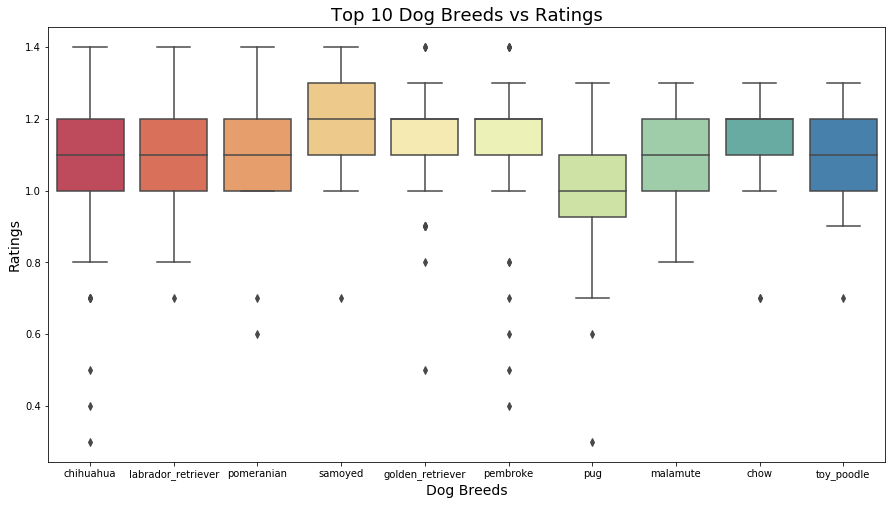

In [161]:
fig = plt.figure(figsize=(15,8))

ax = sns.boxplot(data=twitter_archive_master_top_breeds, x='predicted_dog', y='rating', palette="Spectral")
ax.set_title('Top 10 Dog Breeds vs Ratings', fontsize=18)
ax.set_xlabel('Dog Breeds', fontsize=14)
ax.set_ylabel('Ratings', fontsize=14)

#### Findings
Majority of ratings are under 1.40, but there are some extreme ratings (like 177.60 and 42.00).<br/>
Only 5 tweets have rating more than 1.40.  21% of tweets have rating under 1.00.

There are 113 dog breeds in the data set. I've used 10 top dog breeds to do the analysis.<br/>
Samoyed has higher median and higher interquartile range and pug has lower median and lower interquartile range than the rest of top 10 breed dogs.<br/>
Median rating of all top 10 dog breeds are between 1.0 and 1.2.

It doesn't seem like dog breeds have any correlation with rating.

#### Which variables are associated with retweets and favorite counts?

In [162]:
twitter_archive_master['retweet_count'].describe()

count     1994.000000
mean      2711.898195
std       4682.374483
min         13.000000
25%        607.000000
50%       1310.000000
75%       3118.500000
max      77226.000000
Name: retweet_count, dtype: float64

Mean retweet_count is 2714.04, 25th percentile is 607.00, and 75th percentile 3119.50. Min is 1994.00, and max is 77281.00.

In [163]:
twitter_archive_master['favorite_count'].describe()

count      1994.000000
mean       8836.069208
std       12547.186081
min          80.000000
25%        1923.000000
50%        4039.500000
75%       11126.500000
max      143184.000000
Name: favorite_count, dtype: float64

Mean retweet_count is 8842.77, 25th percentile is 1924.25, and 75th percentile 11137.25. Min is 80.00, and max is 143268.00.

First I'd like to see if retweet counts and favorite counts are correlaed with each other. Are retweet counts go up as favorite counts go up, vice versa?

Text(0,0.5,'Favorite Counts')

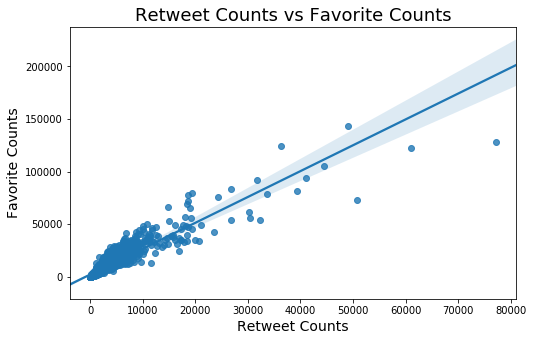

In [164]:
# Scatter plot for retweet counts vs favorite counts with trendline
fig = plt.figure(figsize=(8,5))

ax = sns.regplot(
    x='retweet_count',
    y='favorite_count',
    data=twitter_archive_master
)
ax.set_title('Retweet Counts vs Favorite Counts', fontsize=18)
ax.set_xlabel('Retweet Counts', fontsize=14)
ax.set_ylabel('Favorite Counts', fontsize=14)

In [165]:
# Linear regression model for retweet_count and favorite_count
twitter_archive_master['intercept'] = 1

lm = sms.OLS(twitter_archive_master['retweet_count'], twitter_archive_master[['intercept', 'favorite_count']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                 1.057e+04
Date:                Wed, 13 Jun 2018   Prob (F-statistic):               0.00
Time:                        19:40:51   Log-Likelihood:                -17845.
No. Observations:                1994   AIC:                         3.569e+04
Df Residuals:                    1992   BIC:                         3.571e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept       -312.7707     51.094     -6.121      0.000    -412.974    -212.568
favorite_count     0.3423      0.003    102.797      0.000       0.336       0.349
==============================================================================
Omnibus:                     2259.699   Durbin-Watson:                   1.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           587757.738
Skew:                           5.301   Prob(JB):                         0.00
Kurtosis:                      86.438   Cond. No.                     1.88e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.88e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

As I suspected, favorite_count goes up when retweet_count goes up, vise versa. The plot shows there is strong increaseing trendline also.

Next, I want to took at rating vs retweet counts and favorites counts.  Is higher rating tweets get more retweet_count and favorite counts?

Before I do that, I want to remove couple of outliners from rating.

In [166]:
# Remove outliers from rating.
twitter_archive_master_no_outliers = twitter_archive_master[twitter_archive_master['rating'] < 40]

Text(0,0.5,'Ratings')

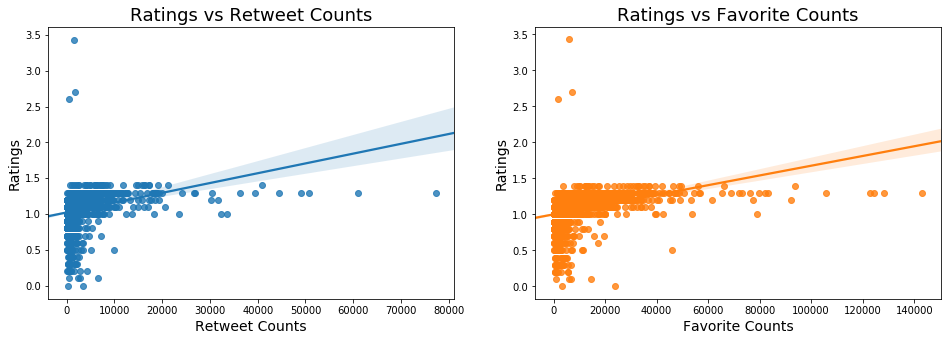

In [167]:
# Scatter plot for rating vs retweet counts/favorite counts with trendline
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,5))

sns.regplot(
    x='retweet_count',
    y='rating',
    data=twitter_archive_master_no_outliers,
    ax=ax1
)
ax1.set_title('Ratings vs Retweet Counts', fontsize=18)
ax1.set_xlabel('Retweet Counts', fontsize=14)
ax1.set_ylabel('Ratings', fontsize=14)

sns.regplot(
    x='favorite_count',
    y='rating',
    data=twitter_archive_master_no_outliers,
    ax=ax2
)
ax2.set_title('Ratings vs Favorite Counts', fontsize=18)
ax2.set_xlabel('Favorite Counts', fontsize=14)
ax2.set_ylabel('Ratings', fontsize=14)

In the plots above, both retweet and favorite counts have increasing trendline indicating there is positive correlation to ratings.

Next, I will explore dog breeds.  Do certain dog breeds get more retweet and favorite counts?
I will use top 10 dog breeds I determined previously to do this analysis.

Removing some outliers from retweet counts.

In [168]:
# Remove outliers from retweet_count
twitter_archive_master_tb_rc = twitter_archive_master_top_breeds[twitter_archive_master_top_breeds['retweet_count'] <= 10000]

Text(0,0.5,'Retweet Counts')

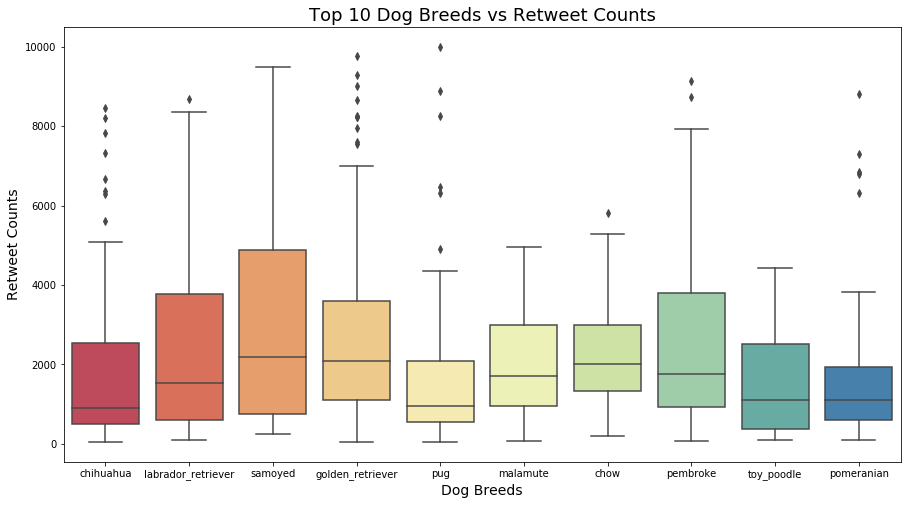

In [169]:
# Boxplot for top 10 dog breeds vs retweet counts
fig = plt.figure(figsize=(15,8))

ax1 = sns.boxplot(data=twitter_archive_master_tb_rc, x='predicted_dog', y='retweet_count', palette="Spectral")
ax1.set_title('Top 10 Dog Breeds vs Retweet Counts', fontsize=18)
ax1.set_xlabel('Dog Breeds', fontsize=14)
ax1.set_ylabel('Retweet Counts', fontsize=14)

The difference is not significant, but samoyed seems to get most retweet counts, and pug and pomeranian tend to get least retweet counts out of all top 10 dog breeds.

Removing some outliers from favorite counts.

In [170]:
# Remove outliers from favorite_counts
twitter_archive_master_tb_fc = twitter_archive_master_top_breeds[twitter_archive_master_top_breeds['favorite_count'] <= 20000]

Text(0,0.5,'Favorite Counts')

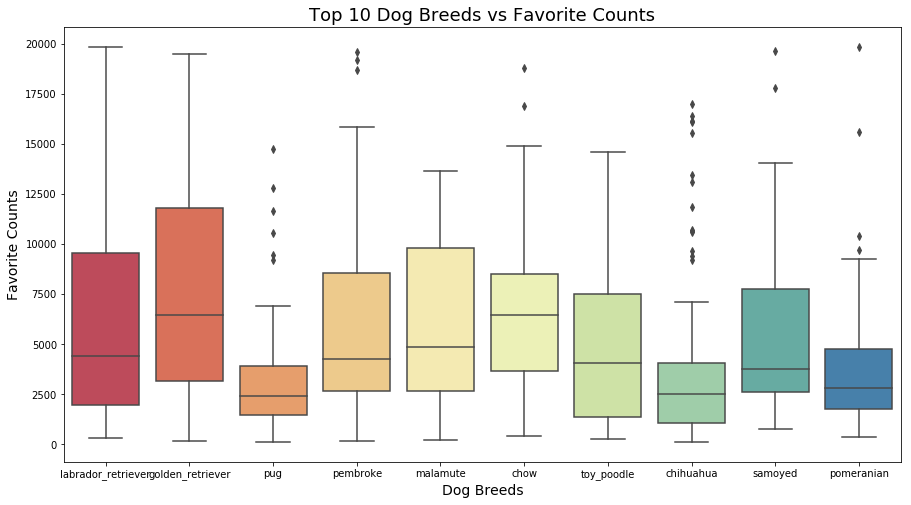

In [171]:
# Boxplot for top 10 dog breeds vs favorite counts
fig = plt.figure(figsize=(15,8))

ax2 = sns.boxplot(data=twitter_archive_master_tb_fc, x='predicted_dog', y='favorite_count', palette="Spectral")
ax2.set_title('Top 10 Dog Breeds vs Favorite Counts', fontsize=18)
ax2.set_xlabel('Dog Breeds', fontsize=14)
ax2.set_ylabel('Favorite Counts', fontsize=14)

Golden retriever and labrador retriever seem to get most favorite counts, and pug and chihuahua tend to get least retweet counts out of all top 10 dog breeds.

For dog breeds, I didn't find any siginificat relationship between dog breeds and retweet and favorite counts.

Lastly, I want to look if life stage of dogs has some assiciation to retweet and favorite counts.

I will filter out tweets which do not have dog life stages.

In [172]:
# Remove tweets which do not have life_stage
twitter_archive_master_life_stages = twitter_archive_master[twitter_archive_master['life_stage'] != 'None']

Removing outliers from retweet counts.

In [173]:
# Remove outliers from retweet_counts
twitter_archive_master_life_stages_rc = twitter_archive_master_life_stages[twitter_archive_master_life_stages['retweet_count'] <= 20000]

Text(0,0.5,'Retweet Counts')

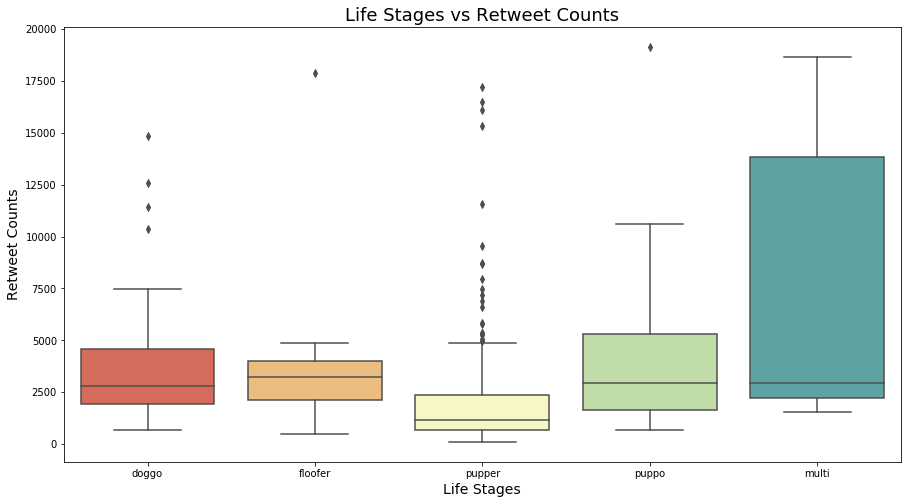

In [174]:
# Boxplot for life stages vs retweet counts
fig = plt.figure(figsize=(15,8))

ax1 = sns.boxplot(data=twitter_archive_master_life_stages_rc, x='life_stage', y='retweet_count', palette="Spectral")
ax1.set_title('Life Stages vs Retweet Counts', fontsize=18)
ax1.set_xlabel('Life Stages', fontsize=14)
ax1.set_ylabel('Retweet Counts', fontsize=14)

Except pupper, median of all other life stages have about the same median. <br/>

It seems like pupper gets lower retweet counts compare to other life stages.<br/>
The multi life stages have large interquatile range.  There very little number of tweets which has life stage 'multi', 6 to be exact. So I would guess the range of these values are wide.

Removing outliners from favorite counts.

In [175]:
# Remove outliers from favorite_count
twitter_archive_master_life_stages_fc = twitter_archive_master_life_stages[twitter_archive_master_life_stages['favorite_count'] <= 20000]

Text(0,0.5,'Favorite Counts')

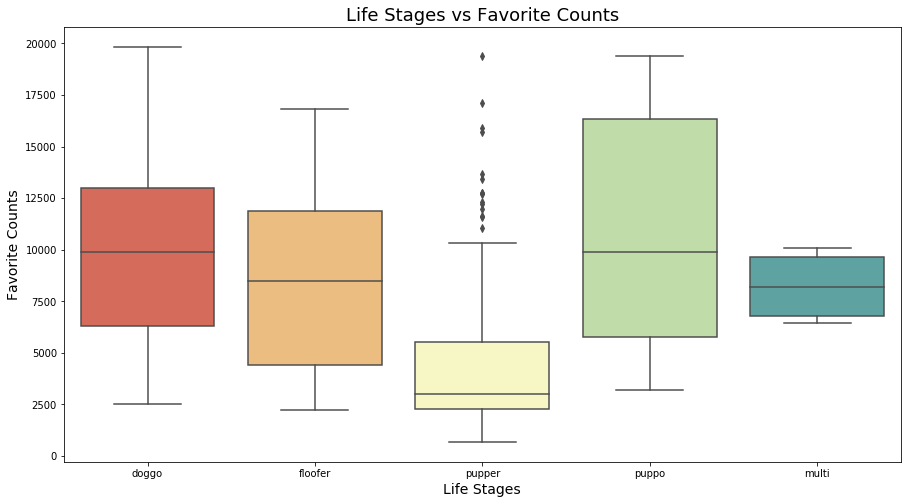

In [176]:
# Boxplot for life stages vs favorite counts
fig = plt.figure(figsize=(15,8))

ax2 = sns.boxplot(data=twitter_archive_master_life_stages_fc, x='life_stage', y='favorite_count', palette="Spectral")
ax2.set_title('Life Stages vs Favorite Counts', fontsize=18)
ax2.set_xlabel('Life Stages', fontsize=14)
ax2.set_ylabel('Favorite Counts', fontsize=14)

There are not significat difference in median of life stages of dogs except pupper. The pupper tends to get lower favorite counts.

Now, putting everything together to fit multiple linear regression model and see if I can find out which data are associated to retweet counts and favorite counts.

In [177]:
# Get dummies for dog breeds and life stages
# Using twitter_archive_master_top_breeds since it only contains tweets with top 10 dog breeds
dummy_df = pd.get_dummies(twitter_archive_master_top_breeds[['predicted_dog', 'life_stage']], drop_first = True)   

# Join dummies to twitter_master_archive
twitter_archive_master_OLS = twitter_archive_master_top_breeds.join(dummy_df)

In [178]:
# Multiple linear regression for retweet counts
twitter_archive_master_OLS['intercept'] = 1

lm = sms.OLS(twitter_archive_master_OLS['retweet_count'], \
             twitter_archive_master_OLS[['intercept', 'rating', 'predicted_dog_chow', 'predicted_dog_golden_retriever', \
                                         'predicted_dog_labrador_retriever', 'predicted_dog_malamute', \
                                         'predicted_dog_pembroke', 'predicted_dog_pomeranian', 'predicted_dog_pug', \
                                         'predicted_dog_samoyed', 'predicted_dog_toy_poodle', 'life_stage_doggo', \
                                         'life_stage_floofer', 'life_stage_multi', 'life_stage_pupper', 'life_stage_puppo']]) 
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          retweet_count   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     6.482
Date:                Wed, 13 Jun 2018   Prob (F-statistic):           4.25e-13
Time:                        19:40:54   Log-Likelihood:                -7221.6
No. Observations:                 729   AIC:                         1.448e+04
Df Residuals:                     713   BIC:                         1.455e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
intercept                        -6821.6092   1376.235     -4.957      0.000   -9523.566   -4119.652
rating                            9115.0548   1213.668      7.510      0.000    6732.265    1.15e+04
predicted_dog_chow                -904.5678    884.492     -1.023      0.307   -2641.087     831.951
predicted_dog_golden_retriever    -370.2874    663.187     -0.558      0.577   -1672.320     931.745
predicted_dog_labrador_retriever    94.5638    705.049      0.134      0.893   -1289.657    1478.785
predicted_dog_malamute             178.1559    999.379      0.178      0.859   -1783.922    2140.234
predicted_dog_pembroke            -606.4624    727.348     -0.834      0.405   -2034.463     821.538
predicted_dog_pomeranian          -627.4714    920.796     -0.681      0.496   -2435.267    1180.324
predicted_dog_pug                 -546.3419    810.826     -0.674      0.501   -2138.233    1045.550
predicted_dog_samoyed              826.0094    931.185      0.887      0.375   -1002.182    2654.201
predicted_dog_toy_poodle          -938.3040    861.286     -1.089      0.276   -2629.265     752.657
life_stage_doggo                  4634.1885   1135.410      4.082      0.000    2405.041    6863.336
life_stage_floofer                1585.0029   2231.917      0.710      0.478   -2796.913    5966.919
life_stage_multi                  1703.3617   2222.246      0.767      0.444   -2659.566    6066.289
life_stage_pupper                 -651.0008    596.593     -1.091      0.276   -1822.290     520.288
life_stage_puppo                   196.4948   1656.930      0.119      0.906   -3056.551    3449.541
==============================================================================
Omnibus:                      974.043   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           187056.654
Skew:                           6.926   Prob(JB):                         0.00
Kurtosis:                      80.242   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [179]:
# Multiple linear regression for favorite counts
twitter_archive_master_OLS['intercept'] = 1

lm = sms.OLS(twitter_archive_master_OLS['favorite_count'], \
             twitter_archive_master_OLS[['intercept', 'rating', 'predicted_dog_chow', 'predicted_dog_golden_retriever', \
                                         'predicted_dog_labrador_retriever', 'predicted_dog_malamute', \
                                         'predicted_dog_pembroke', 'predicted_dog_pomeranian', 'predicted_dog_pug', \
                                         'predicted_dog_samoyed', 'predicted_dog_toy_poodle', 'life_stage_doggo', \
                                         'life_stage_floofer', 'life_stage_multi', 'life_stage_pupper', 'life_stage_puppo']]) 
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     11.46
Date:                Wed, 13 Jun 2018   Prob (F-statistic):           2.04e-25
Time:                        19:40:54   Log-Likelihood:                -7879.7
No. Observations:                 729   AIC:                         1.579e+04
Df Residuals:                     713   BIC:                         1.586e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
intercept                        -2.592e+04   3394.277     -7.636      0.000   -3.26e+04   -1.93e+04
rating                            3.269e+04   2993.330     10.921      0.000    2.68e+04    3.86e+04
predicted_dog_chow               -2106.6385   2181.466     -0.966      0.335   -6389.504    2176.227
predicted_dog_golden_retriever    -144.8609   1635.651     -0.089      0.929   -3356.130    3066.408
predicted_dog_labrador_retriever   601.1614   1738.898      0.346      0.730   -2812.812    4015.135
predicted_dog_malamute            1075.7206   2464.819      0.436      0.663   -3763.451    5914.892
predicted_dog_pembroke            -358.9418   1793.896     -0.200      0.841   -3880.892    3163.008
predicted_dog_pomeranian         -2136.8776   2271.006     -0.941      0.347   -6595.536    2321.780
predicted_dog_pug                 -908.7188   1999.781     -0.454      0.650   -4834.881    3017.444
predicted_dog_samoyed             1534.2437   2296.628      0.668      0.504   -2974.718    6043.205
predicted_dog_toy_poodle         -3136.6077   2124.234     -1.477      0.140   -7307.110    1033.894
life_stage_doggo                  9698.3930   2800.320      3.463      0.001    4200.535    1.52e+04
life_stage_floofer                1762.4241   5504.690      0.320      0.749   -9044.916    1.26e+04
life_stage_multi                  2993.4271   5480.837      0.546      0.585   -7767.081    1.38e+04
life_stage_pupper                -3399.0738   1471.407     -2.310      0.021   -6287.883    -510.265
life_stage_puppo                  3386.9714   4086.571      0.829      0.407   -4636.180    1.14e+04
==============================================================================
Omnibus:                      595.229   Durbin-Watson:                   1.596
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14920.130
Skew:                           3.534   Prob(JB):                         0.00
Kurtosis:                      24.006   Cond. No.                         19.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Interpreting the results for both retweet and favorite counts, rating and life stage 'doggo' are statistically significant.<br/>
Thus, rating and life stage 'doggo' are correlated to both retweet and favorite counts.

<a id='conclusions'></a>
## Conclusions
Retweet counts and favorite counts are correlated with each other. There is positive relationship between retweet and favorite counts. 

<u>Analysis using plots:</u><br>
- For ratings, both retweet and favorite counts have increasing trendline indicating there is positive correlation to ratings.
- For dog breeds, I didn't find any significant relationship between dog breeds and retweet and favorite counts.
- For life stages, it seems like pupper gets lower both retweet and favorite counts compare to other life stages. But the difference is not significant.  I didn't find any significant relationship.

<u>Analysis using multiple linear regression:</u><br/>
- Rating and life stage 'doggo' have strong correlation with retweet and favorite counts.